In [3]:
#Set-up
!pip install -q torch torchvision pillow matplotlib requests

In [4]:
import os
import torch
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image, ImageOps

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [5]:
#Download Sample Images

# Let's download the same sample images.

# Create images directory
os.makedirs("./images", exist_ok=True)

# Download sample images
!wget -q -P ./images/ tench.jpg "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01440764_tench.JPEG"
!wget -q -P ./images/ goldfish.jpg "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01443537_goldfish.JPEG"
!wget -q -P ./images/ tiger_shark.jpg "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01491361_tiger_shark.JPEG"
!wget -q -P ./images/ hammerhead.jpg "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01494475_hammerhead.JPEG"
!wget -q -P ./images/ electric_ray.jpg "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01496331_electric_ray.JPEG"

print("Sample images downloaded:", " ".join(os.listdir("./images")))

Sample images downloaded: n01440764_tench.JPEG.1 n01496331_electric_ray.JPEG n01443537_goldfish.JPEG n01494475_hammerhead.JPEG n01494475_hammerhead.JPEG.1 n01496331_electric_ray.JPEG.1 n01440764_tench.JPEG n01491361_tiger_shark.JPEG.1 n01491361_tiger_shark.JPEG n01443537_goldfish.JPEG.1


In [6]:
#Load ImageNet Class Names

def load_imagenet_classes():
    """Load ImageNet class names from a common source."""
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    response = requests.get(url)
    response.raise_for_status()  # Raise HTTPError for bad responses (4xx, 5xx)
    classes = response.text.strip().split("\n")
    return classes

try:
    imagenet_classes = load_imagenet_classes()
    print(f"Loaded {len(imagenet_classes)} ImageNet classes")
    print("Sample classes:", imagenet_classes[:5])
except requests.exceptions.RequestException:
    print("Could not load ImageNet classes, using fallback")
    imagenet_classes = [f"class_{i}" for i in range(1000)]

Loaded 1000 ImageNet classes
Sample classes: ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']


In [7]:
#Load ResNet-152 Model
# Now let's load the pre-trained ResNet-152 model from `torchvision`.

def load_resnet152_model():
    """Load the pre-trained ResNet-152 model."""
    print("Loading pre-trained ResNet-152 model...")
    # Load pre-trained weights
    weights = models.ResNet152_Weights.IMAGENET1K_V2
    model = models.resnet152(weights=weights)
    model.to(device)
    model.eval()  # Set model to evaluation mode

    # *** THIS IS THE FIX ***
    # The print statement is now correct.
    print("ResNet-152 model loaded successfully!")

    return model, weights.transforms()

# Load the model and get its specific preprocessing transforms
model, preprocess_transform = load_resnet152_model()

Loading pre-trained ResNet-152 model...
ResNet-152 model loaded successfully!


In [8]:
#Image Preprocessing and Visualization
# We will use the transforms recommended by the model weights. Note that PyTorch expects images in `(Batch, Channels, Height, Width)` format.

def preprocess_image_pytorch(image_path):
    """Preprocess image for PyTorch ResNet-152 inference."""
    # Load image
    image = Image.open(image_path).convert("RGB")

    # Apply transforms (resize, center crop, to_tensor, normalize)
    input_tensor = preprocess_transform(image)

    # Add batch dimension and send to device
    input_tensor = input_tensor.unsqueeze(0).to(device)

    # For visualization, we'll use the image *before* normalization
    # We'll just resize/crop it to match what the model sees.
    vis_transform = transforms.Compose([
        transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(224),
    ])
    vis_image = vis_transform(image)

    return input_tensor, vis_image


def show_image_with_predictions(image, predictions, top_k=5):
    """Display image with top-k predictions."""
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Show image
    ax1.imshow(image)
    ax1.set_title("Input Image", fontsize=14)
    ax1.axis("off")

    # Show predictions
    y_pos = np.arange(len(predictions))
    ax2.barh(y_pos, [p[1] for p in predictions])
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([p[0] for p in predictions])
    ax2.set_xlabel("Confidence Score")
    ax2.set_title(f"Top-{top_k} Predictions", fontsize=14)
    ax2.invert_yaxis()  # Top prediction at the top

    plt.tight_layout()
    plt.show()

In [9]:
#*Run Inference on Sample Images

def classify_image_pytorch(model, image_path, top_k=5):
    """Classify a single image and return top-k predictions."""
    input_tensor, original_image = preprocess_image_pytorch(image_path)

    # Run inference
    with torch.no_grad():
        logits = model(input_tensor)

    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(logits[0], dim=0)

    # Get top-k predictions
    top_probs, top_indices = torch.topk(probabilities, top_k)

    # Move to CPU for numpy/list conversion
    top_probs = top_probs.cpu().numpy()
    top_indices = top_indices.cpu().numpy()

    # Format results
    predictions = []
    for idx, prob in zip(top_indices, top_probs):
        class_name = imagenet_classes[idx] if idx < len(imagenet_classes) else f"class_{idx}"
        predictions.append((class_name, float(prob)))

    return predictions, original_image


Classifying: n01496331_electric_ray.JPEG

Top-5 predictions:
1. electric ray: 0.7777 (77.77%)
2. stingray: 0.0517 (5.17%)
3. hammerhead: 0.0004 (0.04%)
4. flatworm: 0.0003 (0.03%)
5. Christmas stocking: 0.0003 (0.03%)


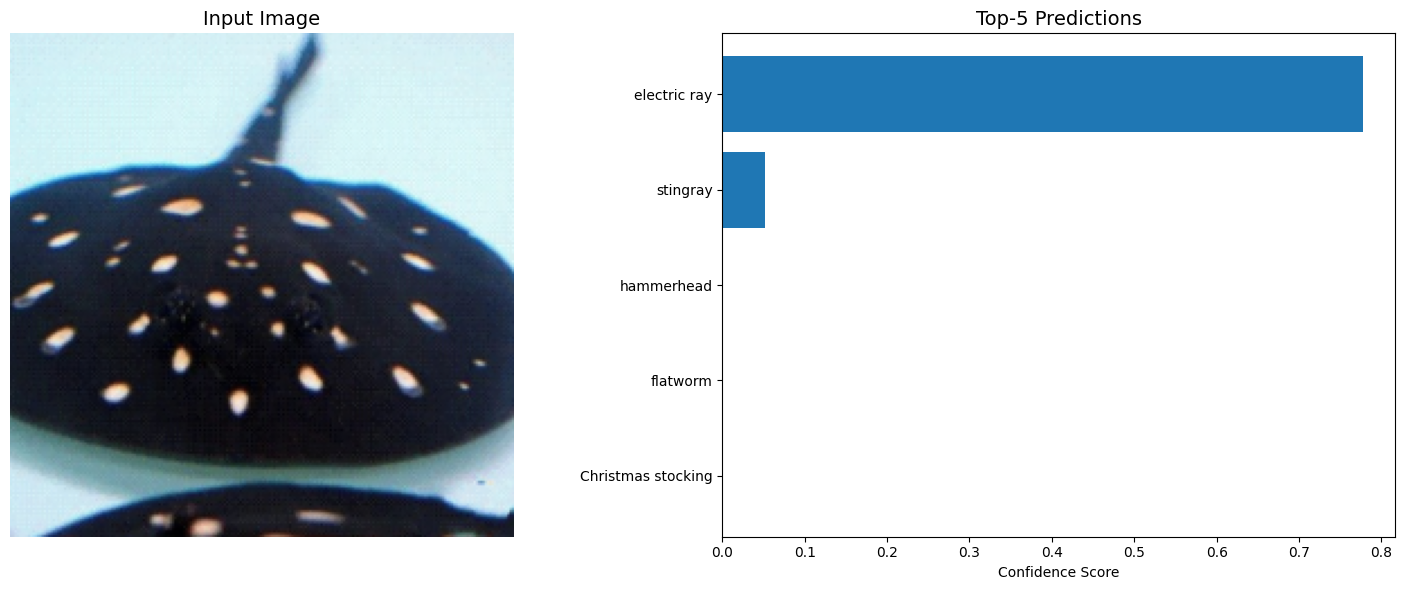


Classifying: n01443537_goldfish.JPEG

Top-5 predictions:
1. goldfish: 0.7532 (75.32%)
2. tench: 0.0010 (0.10%)
3. rock beauty: 0.0007 (0.07%)
4. anemone fish: 0.0005 (0.05%)
5. volcano: 0.0004 (0.04%)


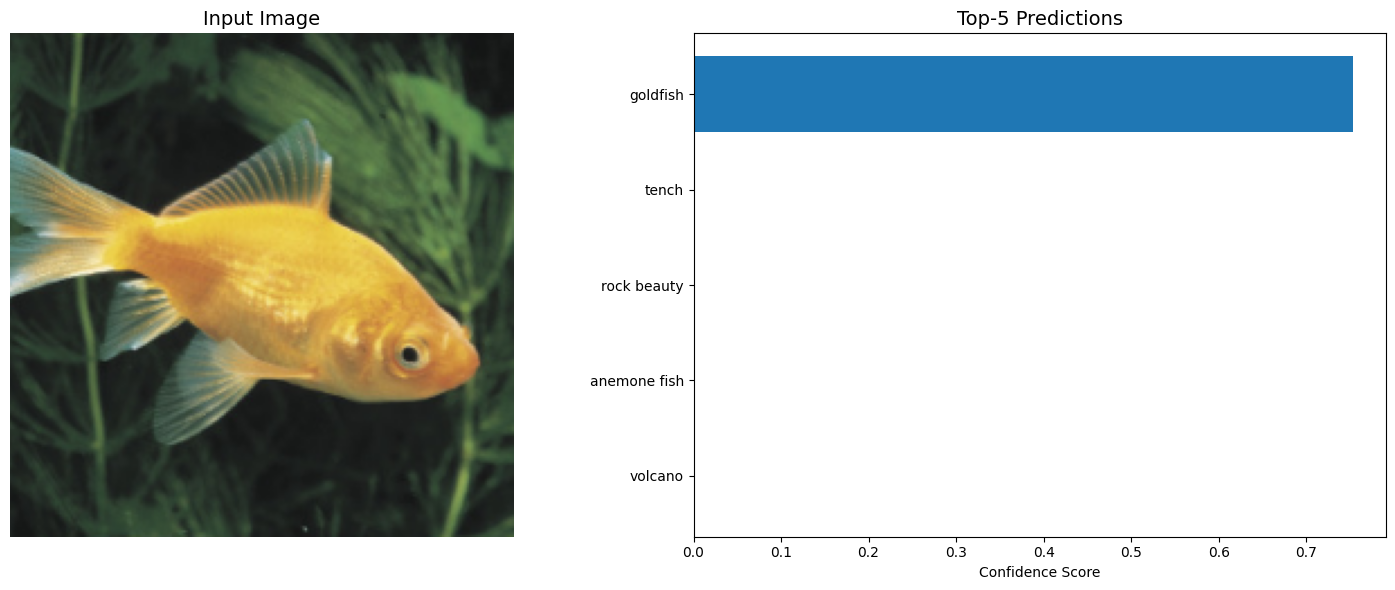


Classifying: n01494475_hammerhead.JPEG

Top-5 predictions:
1. hammerhead: 0.7339 (73.39%)
2. gar: 0.0500 (5.00%)
3. barracouta: 0.0312 (3.12%)
4. swimming trunks: 0.0129 (1.29%)
5. eel: 0.0037 (0.37%)


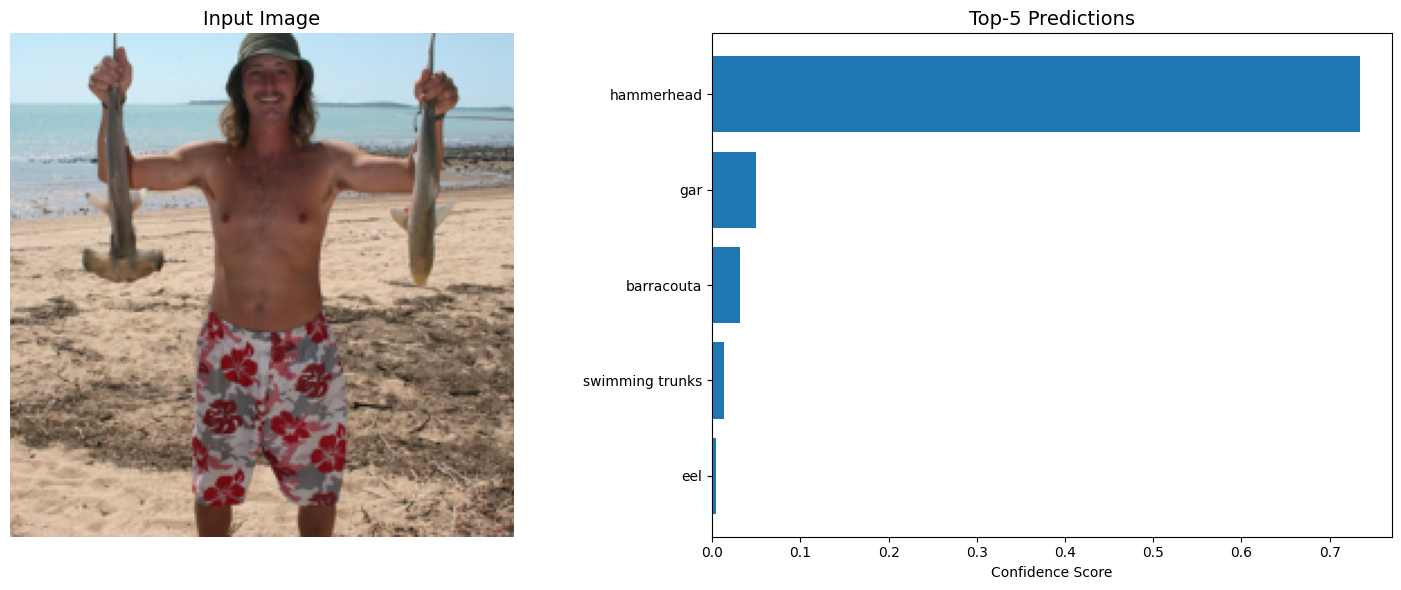


Classifying: n01440764_tench.JPEG

Top-5 predictions:
1. tench: 0.8431 (84.31%)
2. barracouta: 0.0042 (0.42%)
3. gar: 0.0018 (0.18%)
4. goldfish: 0.0012 (0.12%)
5. sturgeon: 0.0008 (0.08%)


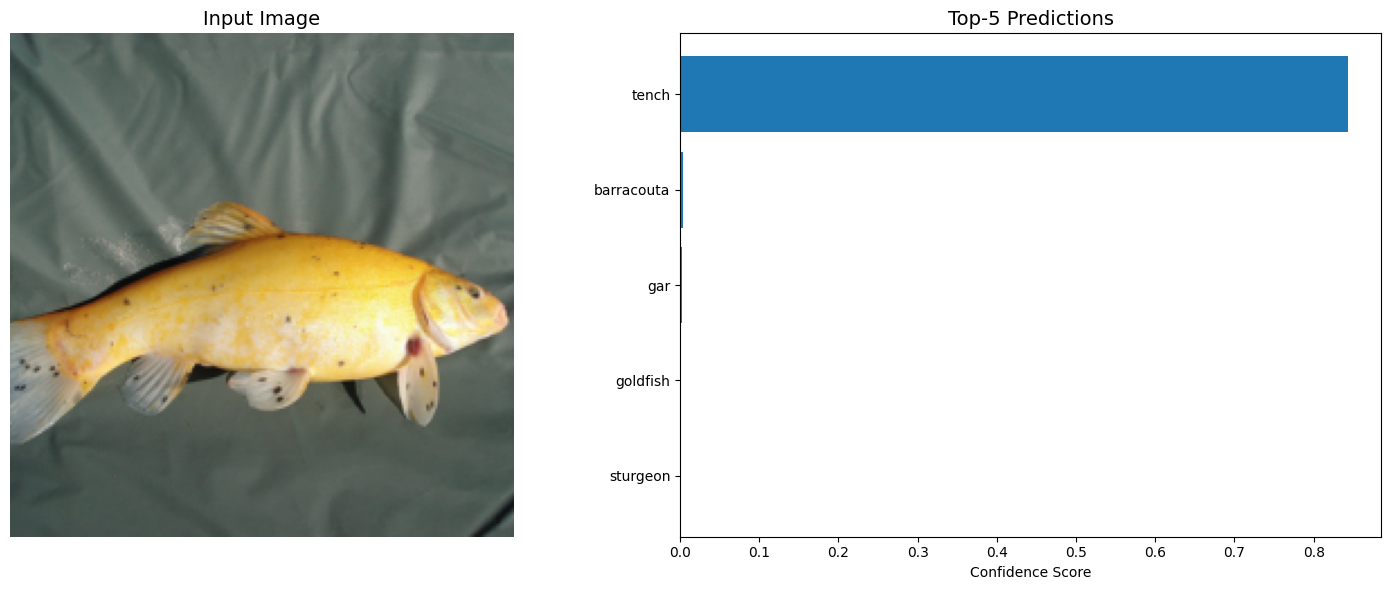


Classifying: n01491361_tiger_shark.JPEG

Top-5 predictions:
1. tiger shark: 0.7709 (77.09%)
2. hammerhead: 0.0021 (0.21%)
3. great white shark: 0.0012 (0.12%)
4. scuba diver: 0.0006 (0.06%)
5. dugong: 0.0004 (0.04%)


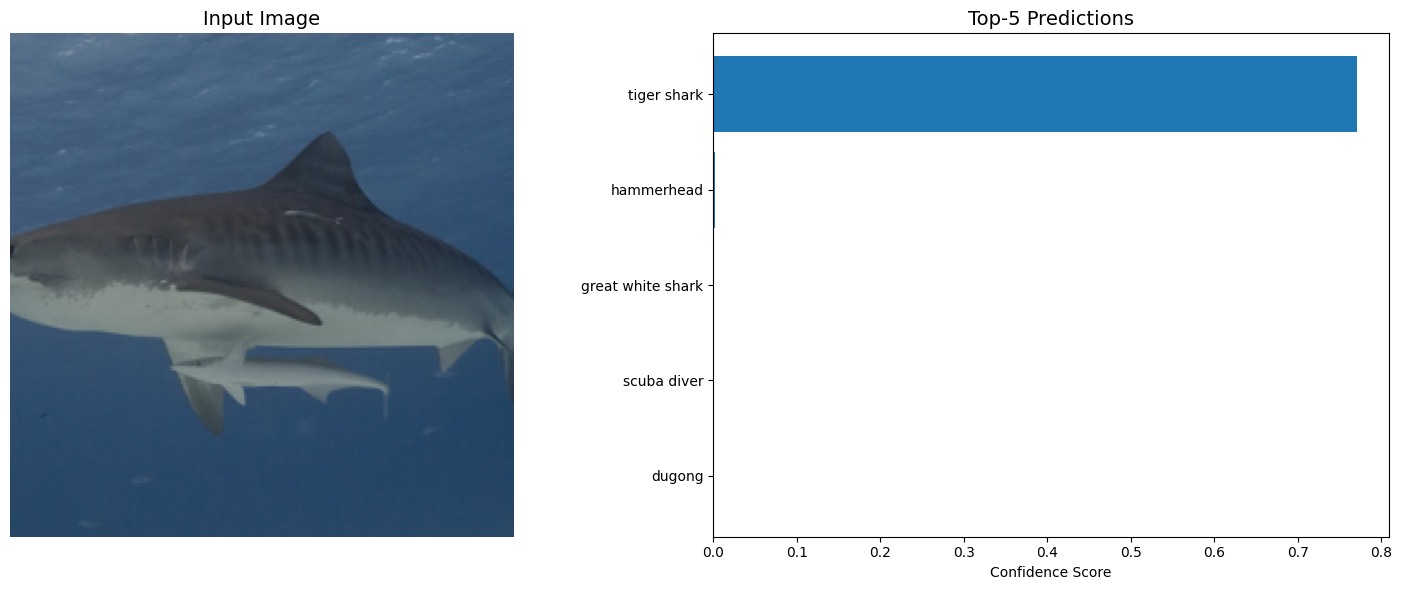

In [10]:
# Test on all images
image_files = [f for f in os.listdir("./images") if f.endswith((".jpg", ".jpeg", ".png", ".JPEG"))]

for image_file in image_files:
    print(f"\n{'=' * 60}")
    print(f"Classifying: {image_file}")
    print(f"{'=' * 60}")

    try:
        predictions, image = classify_image_pytorch(model, f"./images/{image_file}")

        print("\nTop-5 predictions:")
        for i, (class_name, confidence) in enumerate(predictions, 1):
            print(f"{i}. {class_name}: {confidence:.4f} ({confidence * 100:.2f}%)")

        # Show visualization
        show_image_with_predictions(image, predictions)

    except Exception as e:
        print(f"Error processing {image_file}: {e}")

# ----------------------------------------------------------------------
# ## **Conclusion**
#
# This notebook demonstrates how to use the ResNet-152 model from `torchvision` to perform ImageNet classification.